# Python for Data Analysis
When we work with big datasets on Hadoop, we use Spark to distribute the processing across a cluster of machines. However, the data is often aggregated to a point where it makes more sense to just load it onto the client machine and work with it directly. This is useful for visualizing the results. Also, sometimes it makes sense to work with a small sample of the entire dataset and work with it locally, in order to quickly figure out some rough estimates and correlations, before crunching the entire dataset.

For Python there is a widely used package for data analysis called Pandas. Pandas revolves around a concept called data frames, which is basically Excel on steroids.

Data frames have rows and columns, just like spreadsheets. Columns have names and rows have a number (the index). Let's look at some examples.

In [1]:
# Import pandas, the pd shorthand is idiomatic in the Python data community
import pandas as pd

# FizzBuzz, again, for the examples
word = lambda x: ["{0}", "Fizz", "Buzz", "FizzBuzz"][(x % 3 == 0) | ((x % 5 == 0) << 1)].format(x)

## Constructing a data frame
You can create a data frame using its constructor, which can take a number of different types and shapes of parameters. One form that we'll be using frequently is just passing it a list of dictionaries (the Python naming of hashtables).

In [2]:
# Create some data
data = [{
    'number': n,
    'fizzbuzz': word(n)
    } for n in range(1,22)]

# We explicitly list the columns to force the column order, but you don't have to
data_frame = pd.DataFrame(data, columns=['number', 'fizzbuzz'])

data_frame

,number,fizzbuzz
0,1,1
1,2,2
2,3,Fizz
3,4,4
4,5,Buzz
5,6,Fizz
6,7,7
7,8,8
8,9,Fizz
9,10,Buzz


## RDDs and data frames
Often, the result of some operations on Spark RDDs are small datasets, like the histogram we created in the previous exercise. In this case, we usually like to store those results in a data frame, so we can visualize them nicely and easily. Here, we take the histogram from the previous exercise and collect it into a data frame.

In [3]:
fizzbuzz = sc.textFile('fizzbuzz.csv')
parsed = fizzbuzz.map(lambda line: tuple(line.strip().split(',')))
def fizzbuzz_key(fb):
    if fb == 'Fizz' or fb == 'Buzz' or fb == 'FizzBuzz':
        return fb
    else:
        return 'Number'

data = parsed\
.map(lambda (n, fb): (fizzbuzz_key(fb), 1))\
.reduceByKey(lambda x,y: x + y)\
.collect()

data_frame = pd.DataFrame(data, columns=['type', 'count'])
data_frame

,type,count
0,FizzBuzz,13333
1,Number,106667
2,Fizz,53333
3,Buzz,26667


## Plotting
Data frames come with a number of built-in visualization methods. These make use of a Python package called matplotlib, which integrates with IPython notebook. In order to ensure proper rendering of figures, we have to instruct the kernel to inline the plots into the notebook. From there on, plotting is relatively easy.

For the all the available plots and options, see the Pandas [API doc for `plot(...)`](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.plot.html).

In [4]:
# This instructs the notebook to inline plots
%pylab inline

Populating the interactive namespace from numpy and matplotlib


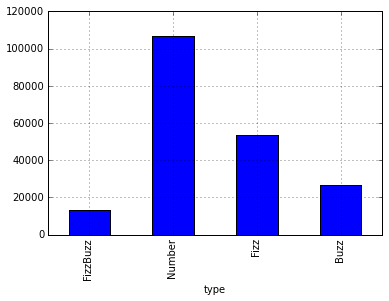

In [5]:
data_frame.plot(kind='bar', x='type', y='count', legend=False)

## Sampling
Another common use case is to take a sample from a large dataset (RDD) and use the sample for a local analysis on a smaller scale, before applying the same analysis to the entire dataset. Here we take a sample of the fizzbuzz data and use the sample to figure out if there is a relation between the number being divisable by three and the label.

A Pandas data frame is not unlike a dictionary. You can add columns by transforming other columns in different ways. Here we take the number column and add a column based on whether the number column is divisable by three.

The file that we have loaded contains only strings, while we need to parse them when working with numbers. For this reason we need to map the parsed results to numbers where necessary.

In [6]:
# Take a 1% sample and load it into a DataFrame
fizzbuzz_data_frame = pd.DataFrame(
    parsed.map(lambda (n, fb): (int(n), fb)).sample(False, 0.01, 0).collect(),
    columns=['number', 'fizzbuzz'])

In [18]:
# Have a look at some rows from the top
fizzbuzz_data_frame.head(20)

,number,fizzbuzz
0,31,31
1,177,Fizz
2,216,Fizz
3,257,257
4,301,301
5,393,Fizz
6,493,493
7,503,503
8,574,574
9,577,577


## Vectorized operations
After having a closer look at our sample above, we suspect that there is some kind of relation between a number being divisible by 3 and the value for the FizzBuzz output. In order to validate this, we add a column to the data frame that indicates if the number is divisble by three (True) or not (False).

Pandas data frames have the ability to perform so called vectorized operations. This means that you write an operation as if it was performed on a single value, but actually apply it to an entire row and/or column at once. We use this to transform an entire column into a new one in one go.

Another way of performing a vectorized operation is to apply one function to all values in a column at once. This is similar to a map(...) operation in functional programming.

Here we use both forms to add some information to our data frame.

In [9]:
# Add a column for divsibility by three and for the type of FizzBuzz result
fizzbuzz_data_frame['by_three'] = fizzbuzz_data_frame.number % 3 == 0
fizzbuzz_data_frame['type'] = fizzbuzz_data_frame.fizzbuzz.apply(fizzbuzz_key)
fizzbuzz_data_frame.head(20)

,number,fizzbuzz,by_three,type
0,31,31,False,Number
1,177,Fizz,True,Fizz
2,216,Fizz,True,Fizz
3,257,257,False,Number
4,301,301,False,Number
5,393,Fizz,True,Fizz
6,493,493,False,Number
7,503,503,False,Number
8,574,574,False,Number
9,577,577,False,Number


## The results
Next we use Pandas' built in methods for grouping and counting to look into the supposed relation between number and FizzBuzz output. We group the data frame by the `type` and `by_three` columns and count how often each combination occurs. Here we find out that a number divisible by 3 will never result in the number being output by the FizzBuzz program. Most of the times a number that is divisible by 3 will result in the Fizz output and sometimes in the FizzBuzz output, but also never in Buzz. We could be on to something!

In [13]:
fizzbuzz_data_frame.groupby(['type', 'by_three'])['fizzbuzz'].count()

type      by_three
Buzz      False        314
Fizz      True         532
FizzBuzz  True         156
Number    False       1088
Name: fizzbuzz, dtype: int64

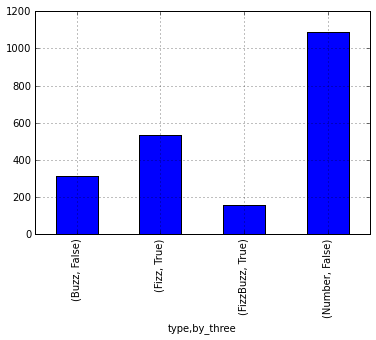

In [14]:
# This can also be plotted
fizzbuzz_data_frame.groupby(['type', 'by_three'])['fizzbuzz'].count().plot(kind='bar')